### Example for computation of SnFR data

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums, spearmanr, f_oneway, kruskal
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

In [2]:
from pathlib import Path
vol_file = '../SnFR_data/SnFR_Log_DRN_Exp.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/SnFRData/'
dir_folder = Path(dat_folder)

In [3]:
frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15
t_valid = 16
color_list = ['k', 'r', 'b']

In [4]:
row = dat_xls_file.iloc[0]

In [5]:
row

Unnamed: 0                                          0
folder                                       04102019
fish                                          Fish1-1
task                                  Gain adaptation
area                                             GABA
rootDir         /mnt/Dali/Takashi/Cezanne/SPIM_newPC/
pixeldenoise                                     True
registration                                     True
detrend                                          True
demix                                            True
denoise                                          True
Name: 0, dtype: object

In [6]:
folder = row['folder']
fish = row['fish']
dff_dir = dat_folder+f'{folder}/{fish}/Data/'

In [9]:
!ls '/nrs/ahrens/Ziqiang/Takashi_DRN_project/SnFRData/04102019/Fish1-1/Data/'

components.npz			  motion_fix_.npy
components_rlt.pkl		  proc_detrend.tmp
finished_detrend.tmp		  proc_local_denoise_demix.tmp
finished_local_denoise_demix.tmp  proc_pixel_denoise.tmp
finished_pixel_denoise.tmp	  proc_registr.tmp
finished_registr.tmp		  Raw_frame_0.png
imgDMotion_ave.npy		  Y_2dnorm.npz
imgDMotion.tif			  Y_d.tif
imgDMotionVar.npy		  Y_local.npz
imgDNoMotion.tif		  Y_local_std.npy


In [11]:
A = np.load(dff_dir+'components.npz', allow_pickle=True)['A_']

In [13]:
from skimage.io import imread

In [15]:
Y_ = imread(dff_dir+'imgDMotion.tif')

In [20]:
t, x, y = Y_.shape

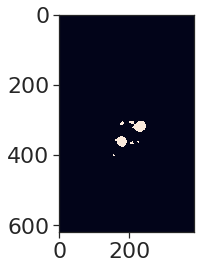

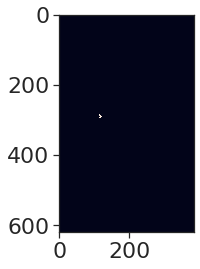

In [23]:
for a_ in A.T:
    _ = a_>a_.max()*.2
    plt.imshow(_.reshape(x, y, order='F'))
    plt.show()

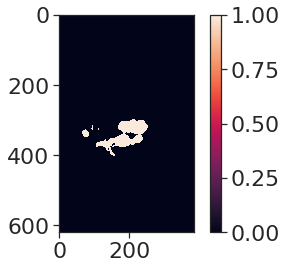

In [32]:
plt.imshow((Y_.mean(axis=0)>(Y_.mean(axis=0).max()*0.2)).astype('int'))
plt.colorbar()
plt.show()

In [33]:
valid_pix = Y_.mean(axis=0)>100

In [36]:
F = Y_[:, valid_pix].mean(axis=-1)

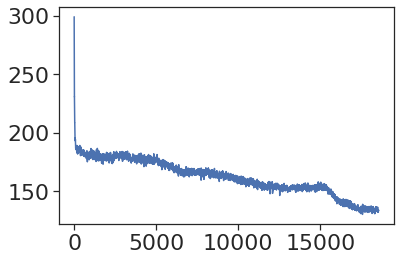

In [37]:
plt.plot(F)

In [38]:
def baseline(data, window=100, percentile=15, downsample=1, axis=-1):
    """
    Get the baseline of a numpy array using a windowed percentile filter with optional downsampling
    data : Numpy array
        Data from which baseline is calculated
    window : int
        Window size for baseline estimation. If downsampling is used, window shrinks proportionally
    percentile : int
        Percentile of data used as baseline
    downsample : int
        Rate of downsampling used before estimating baseline. Defaults to 1 (no downsampling).
    axis : int
        For ndarrays, this specifies the axis to estimate baseline along. Default is -1.
    """
    from scipy.ndimage.filters import percentile_filter
    from scipy.interpolate import interp1d
    from numpy import ones

    size = ones(data.ndim, dtype='int')
    size[axis] *= window//downsample

    if downsample == 1:
        bl = percentile_filter(data, percentile=percentile, size=size)
    else:
        slices = [slice(None)] * data.ndim
        slices[axis] = slice(0, None, downsample)
        data_ds = data[slices]
        baseline_ds = percentile_filter(data_ds, percentile=percentile, size=size)
        interper = interp1d(range(0, data.shape[axis], downsample), baseline_ds, axis=axis, fill_value='extrapolate')
        bl = interper(range(data.shape[axis]))
    return bl

In [43]:
F_b = baseline(F, window=1000, percentile=20)

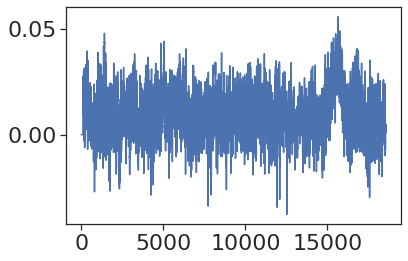

In [46]:
dFF = F/F_b-1
dFF[:100] = 0
plt.plot(dFF)

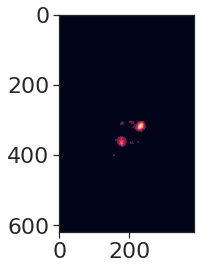

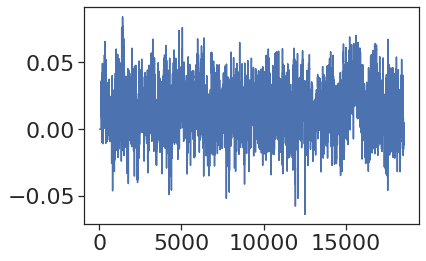

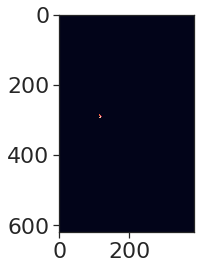

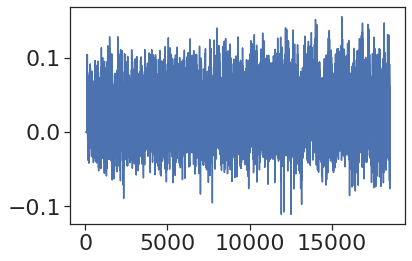

In [58]:
for a_ in A.T:
    _ = a_
    _[a_<a_.max()*.2] = 0
    plt.imshow(_.reshape(x, y, order='F'))
    plt.show()
    c = np.matmul(Y_.reshape(t, x*y, order='F'), _[:, np.newaxis])
    c_b = baseline(c, window=1000, percentile=20, axis=0)
    dFF = c/c_b-1
    dFF[:100] = 0
    plt.plot(dFF)
    plt.show()